In [1]:
import pdal
import numpy as np
import pandas as pd
import laspy
import open3d as o3d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import statistics

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Step 1: Read the .laz file
file_path = 'CSF_Filtering_Output.laz'  
lidar_data = laspy.read(file_path)

# Step 2: Prepare the data
# Extract the coordinates
coords = np.vstack((lidar_data.x, lidar_data.y, lidar_data.z)).transpose()

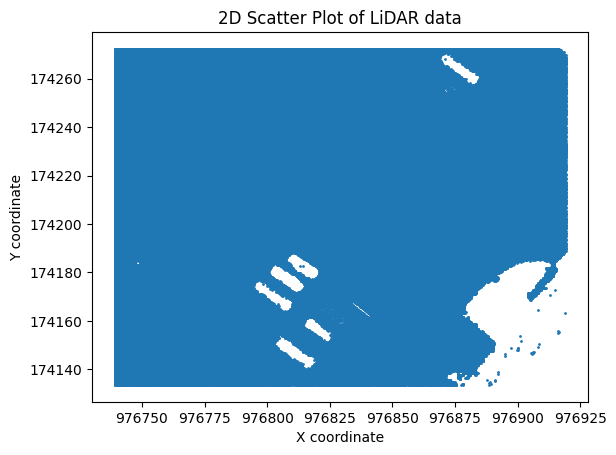

In [3]:
plt.scatter(coords[:, 0], coords[:, 1], s=1)  
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('2D Scatter Plot of LiDAR data')
plt.show()

z_mean=8.504140004296662
z_std=0.6036658541744861


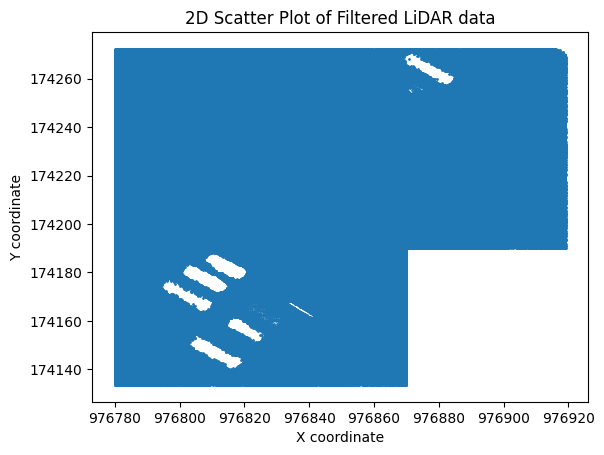

In [4]:
#Step 2: Noise reduction: filter based on Z value
# Calculate the mean and standard deviation
z_mean = np.mean(coords[:, 2])
z_std = np.std(coords[:, 2])
print(f"z_mean={z_mean}")
print(f"z_std={z_std}")

# Define a threshold for Z values, e.g., 2 standard deviations
threshold = 2
# Create a mask to filter out the points
mask = np.abs(coords[:, 2] - z_mean) < threshold * z_std
data_filtered = coords[mask]

# Region filtering: exclude points within a specified bounding box
# Define bounding box limits
x_limit_right  = 976870  
y_limit_bottom  = 174190  
x_limit_left=976780

# Create a mask to exclude points
mask_exclude_right = (data_filtered[:, 0] > x_limit_right) & (data_filtered[:, 1] < y_limit_bottom)
mask_exclude_left = (data_filtered[:, 0] < x_limit_left) 
mask = ~(mask_exclude_right | mask_exclude_left)
coords = data_filtered[mask]

# Plot the filtered data
plt.scatter(coords[:, 0], coords[:, 1], s=1)
plt.title("2D Scatter Plot of Filtered LiDAR data")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()


In [5]:
points_2d = coords[:, :2]

In [14]:
#Step 3: hole detection

#calculate the area of a triangle from its vertices
def calculate_area(v1, v2, v3):
    # Using Heron's formula
    a = np.linalg.norm(v2 - v1)
    b = np.linalg.norm(v3 - v2)
    c = np.linalg.norm(v1 - v3)
    s = (a + b + c) / 2
    area = s * (s - a) * (s - b) * (s - c)
    
    # Check if the area calculation is negative due to floating point inaccuracy
    if area < 0 and np.isclose(area, 0):
        area = 0
    return np.sqrt(area) if area >= 0 else 0

def calculate_aspect_ratio(v1, v2, v3):
    edges = [np.linalg.norm(v2 - v1), np.linalg.norm(v3 - v2), np.linalg.norm(v1 - v3)]
    max_edge = max(edges)
    min_edge = min(edges)
    return max_edge / min_edge if min_edge > 0 else np.inf
    
def detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold):
    tri = Delaunay(points_2d)
    hole_candidates = []
    aspect_ratios = []

    for t in tri.simplices:
        v1, v2, v3 = points_2d[t[0]], points_2d[t[1]], points_2d[t[2]]
        area = calculate_area(v1, v2, v3)
        aspect_ratio = calculate_aspect_ratio(v1, v2, v3)

        aspect_ratios.append(aspect_ratio)
        if threshold_area < area < max_area and aspect_ratio < aspect_ratio_threshold:
            hole_candidates.extend(t)

    #print(f"Max aspect ratios of all triangles: {max(aspect_ratios)}")
    #print(f"Mean aspect ratios of all triangles: {statistics.mean(aspect_ratios)}")
    return np.unique(hole_candidates), tri

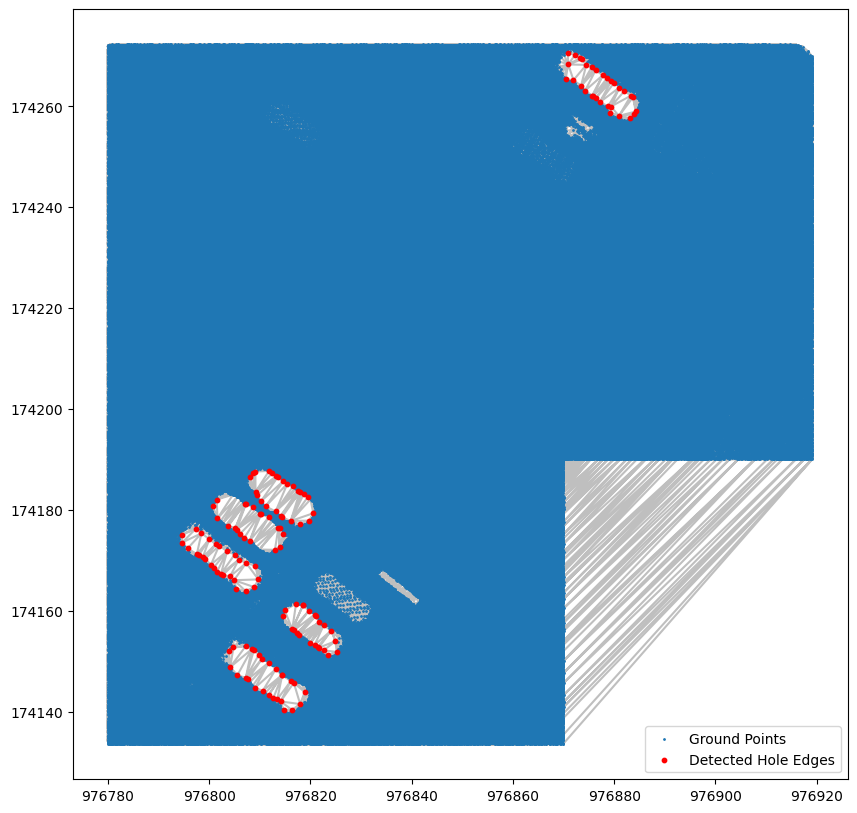

In [15]:
max_area=6
threshold_area = 1
aspect_ratio_threshold = 6 
points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)

plt.figure(figsize=(10, 10))
plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Ground Points', s=1)
plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label='Detected Hole Edges', s=10)
plt.legend()
plt.show()

average_spacing: 0.07417840745472833


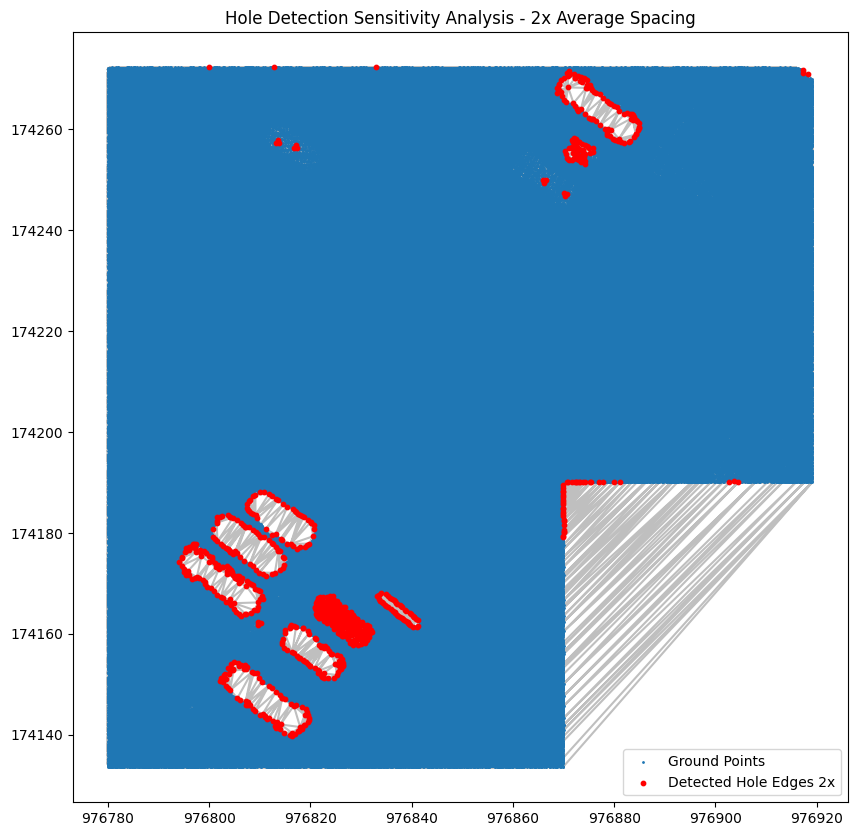

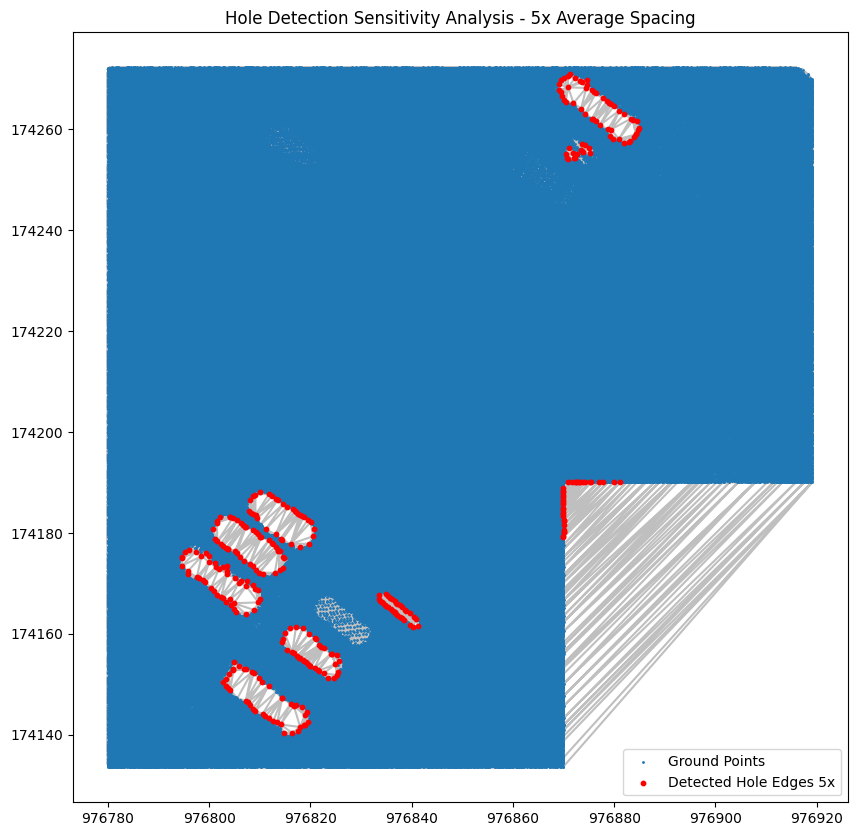

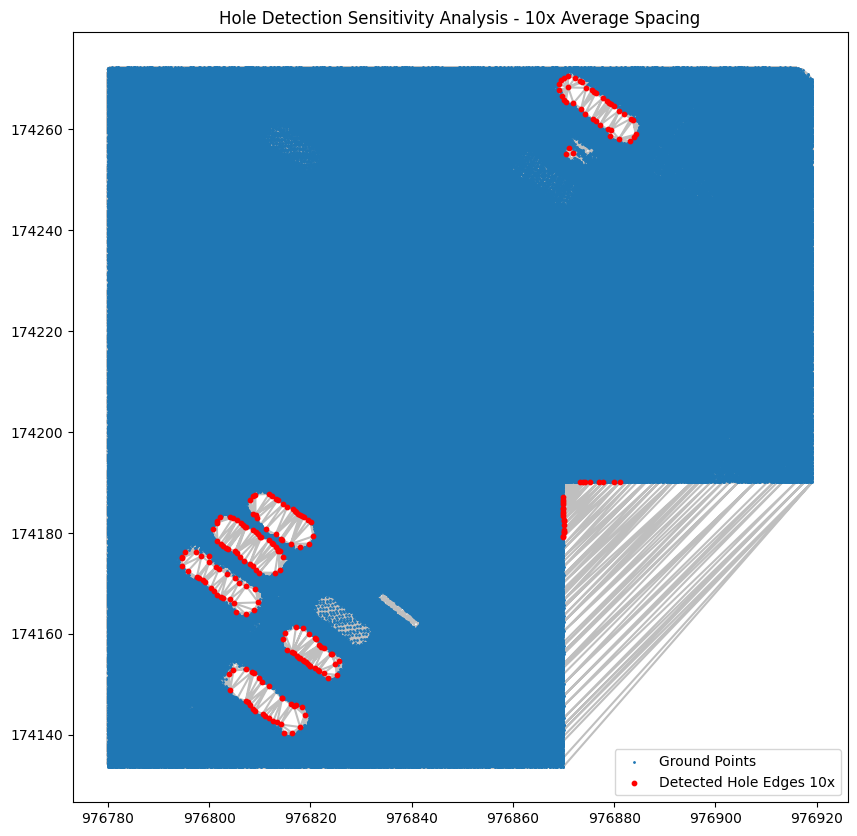

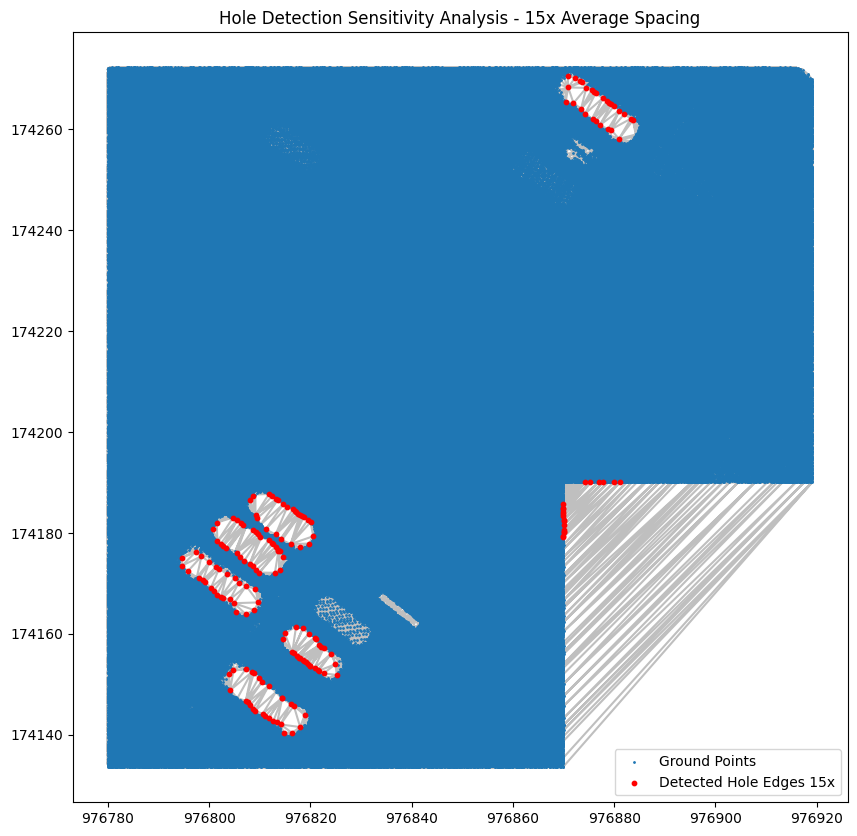

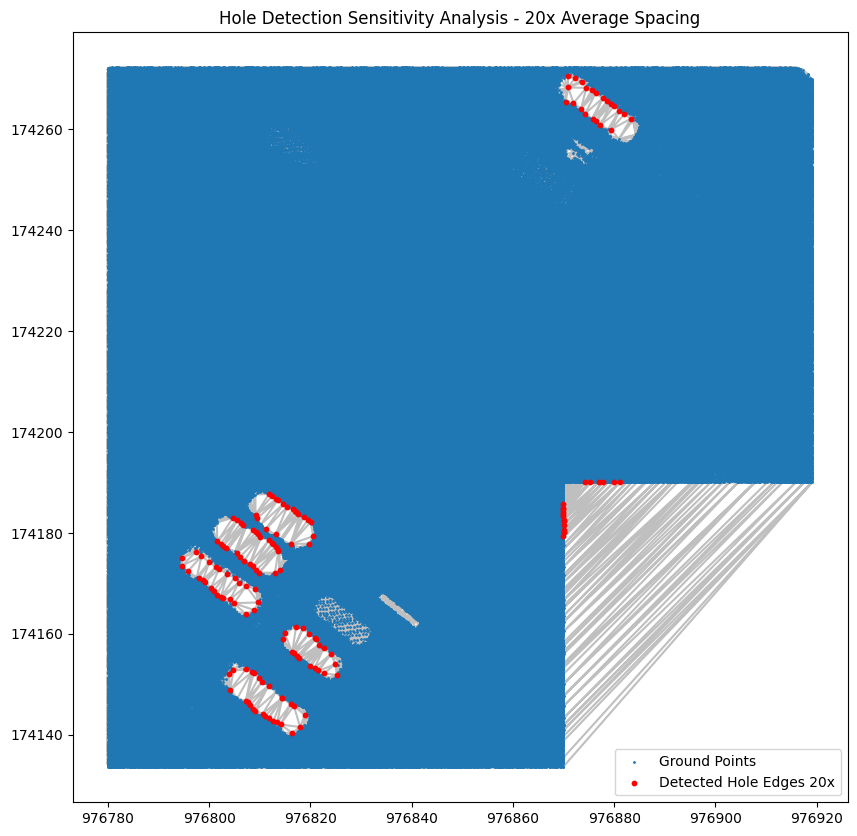

In [12]:
# Perform sensitivity analysis
from scipy.spatial import KDTree

def calculate_average_spacing(points_2d):
    tree = KDTree(points_2d)
    distances, _ = tree.query(points_2d, k=2) 
    average_spacing = np.mean(distances[:, 1])  
    return average_spacing

average_spacing = calculate_average_spacing(points_2d)
print(f"average_spacing: {average_spacing}")

multiples = [2, 5, 10, 15, 20]

for multiple in multiples:
    threshold_area = multiple * average_spacing
    max_area = 50 * average_spacing 
    aspect_ratio_threshold = 100 
    
    points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)
    
    plt.figure(figsize=(10, 10))
    plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
    plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Ground Points', s=1)
    plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label=f'Detected Hole Edges {multiple}x', s=10)
    plt.legend()
    plt.title(f'Hole Detection Sensitivity Analysis - {multiple}x Average Spacing')
    plt.show()


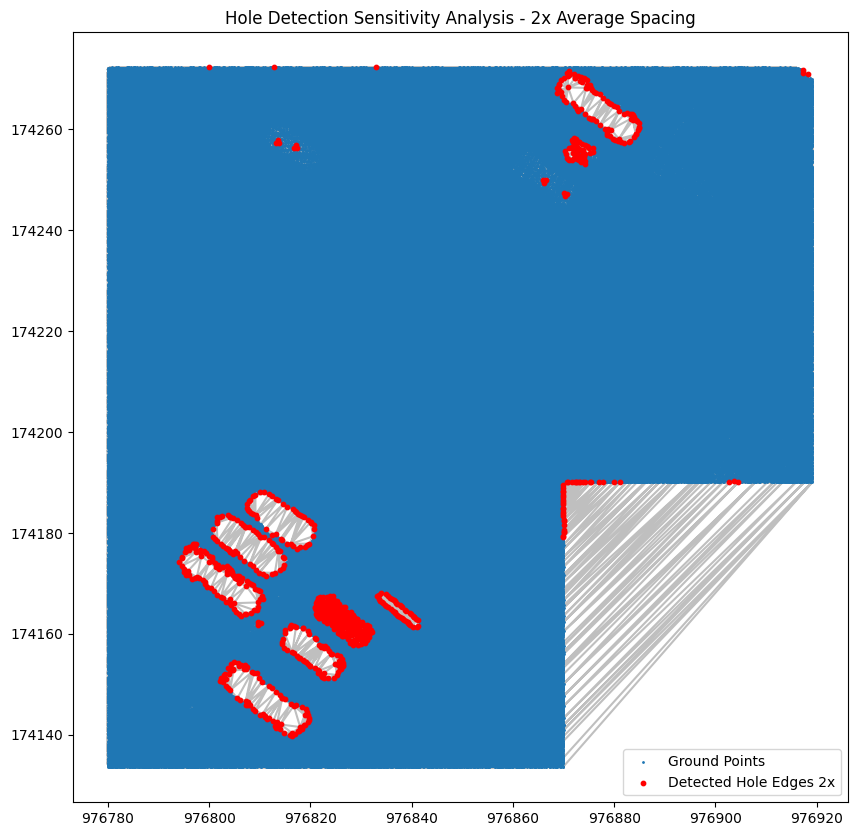

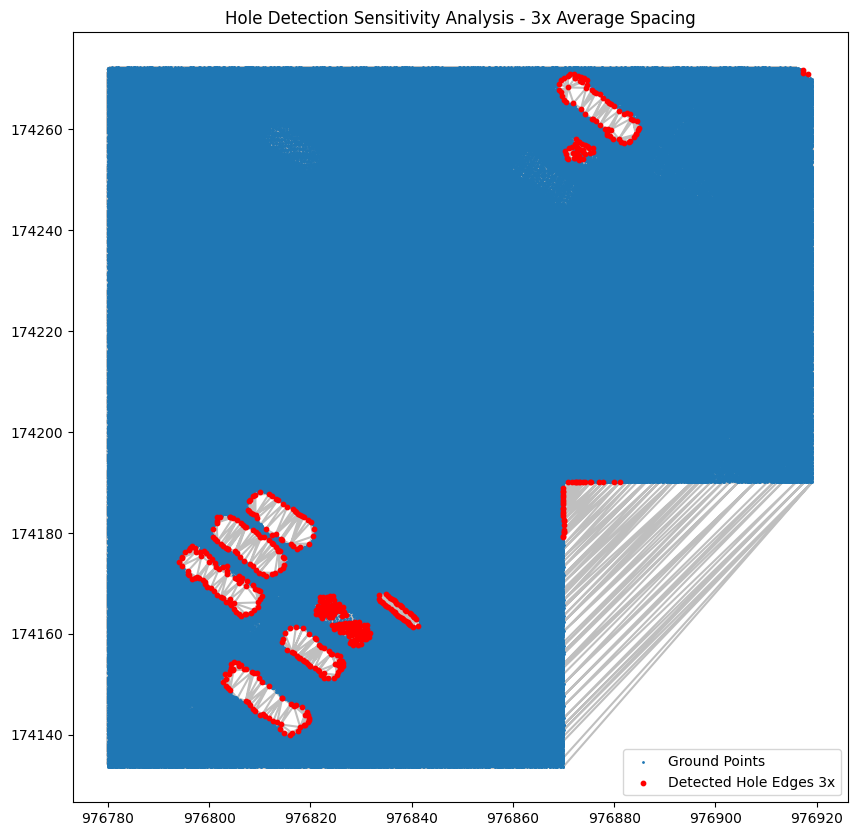

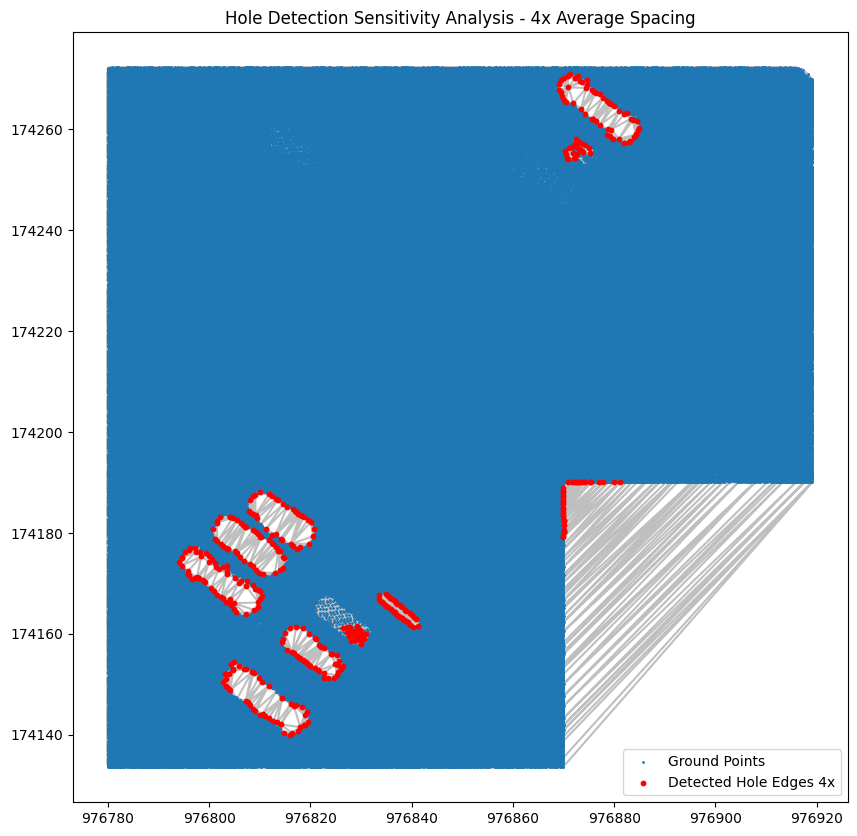

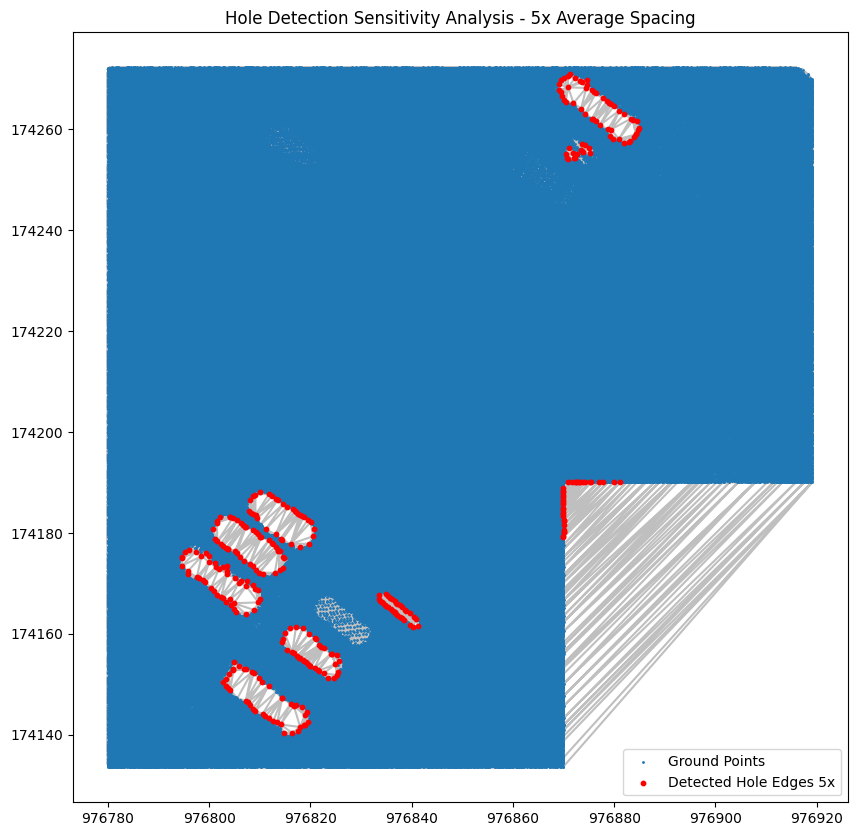

In [16]:
multiples = [2, 3, 4, 5]

for multiple in multiples:
    threshold_area = multiple * average_spacing
    max_area = 50 * average_spacing 
    aspect_ratio_threshold = 100 
    
    points_around_holes, triangulation = detect_holes(points_2d, threshold_area, max_area, aspect_ratio_threshold)
    
    plt.figure(figsize=(10, 10))
    plt.triplot(points_2d[:, 0], points_2d[:, 1], triangulation.simplices.copy(), color='gray', alpha=0.5)
    plt.scatter(points_2d[:, 0], points_2d[:, 1], label='Ground Points', s=1)
    plt.scatter(points_2d[points_around_holes, 0], points_2d[points_around_holes, 1], color='r', label=f'Detected Hole Edges {multiple}x', s=10)
    plt.legend()
    plt.title(f'Hole Detection Sensitivity Analysis - {multiple}x Average Spacing')
    plt.show()


In [9]:
calculate_average_spacing(points_2d)

0.07417840745472833

Max aspect ratios of all triangles: 1351.8761041048779 <br>
Mean aspect ratios of all triangles: 2.035603166641976

In [7]:
'''
tri = Delaunay(points_2d)
aspect_ratios = []
for t in tri.simplices:
    v1, v2, v3 = points_2d[t[0]], points_2d[t[1]], points_2d[t[2]]
    aspect_ratio = calculate_aspect_ratio(v1, v2, v3)
    aspect_ratios.append(aspect_ratio)
print(f"Max aspect ratios of all triangles: {max(aspect_ratios)}")
print(f"Mean aspect ratios of all triangles: {statistics.mean(aspect_ratios)}")
'''

'\ntri = Delaunay(points_2d)\naspect_ratios = []\nfor t in tri.simplices:\n    v1, v2, v3 = points_2d[t[0]], points_2d[t[1]], points_2d[t[2]]\n    aspect_ratio = calculate_aspect_ratio(v1, v2, v3)\n    aspect_ratios.append(aspect_ratio)\nprint(f"Max aspect ratios of all triangles: {max(aspect_ratios)}")\nprint(f"Mean aspect ratios of all triangles: {statistics.mean(aspect_ratios)}")\n'

In [10]:
'''
# Perform Delaunay triangulation
tri = Delaunay(points_2d)

# Plot the triangulation
plt.triplot(points_2d[:,0], points_2d[:,1], tri.simplices.copy())
plt.plot(points_2d[:,0], points_2d[:,1], 'o')
plt.show()

# Identify large triangles
max_area=8
threshold_area = 2
large_triangles = []

for t in tri.simplices:
    # Extract the vertices for this triangle
    v1, v2, v3 = points_2d[t[0]], points_2d[t[1]], points_2d[t[2]]
    
    # Compute the area of the triangle
    a = np.linalg.norm(v2 - v1)
    b = np.linalg.norm(v3 - v2)
    c = np.linalg.norm(v1 - v3)
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    
    if area > threshold_area and area < max_area:
        large_triangles.append(t)
        

# Extract points around holes
points_around_holes = np.unique(np.concatenate(large_triangles))

# Visualize holes
plt.figure(figsize=(10, 10))
plt.scatter(points_2d[:,0], points_2d[:,1], label='LiDAR Points')
plt.scatter(points_2d[points_around_holes,0], points_2d[points_around_holes,1], c='r', label='Points around holes')
plt.legend()
plt.show()

SyntaxError: incomplete input (4233745262.py, line 1)

In [ ]:
'''
#saving the centroid of large triangles
centroids = [points_2d[t].mean(axis=0) for t in large_triangles]
np.savetxt('hole_centroids.csv', centroids, delimiter=',')